# Wiki Networking

### Introduction

In this notebook, we will map out a social network created from Wikipedia articles. Web crawling and text mining tools are available on the [Wiki Networking - Text Mining Tools](./Wiki%20Networking%20-%20Text%20Mining%20Tools.ipynb) notebook. To begin, we will need to define which data file we are using and the name of our output image file.

In [18]:
data_file = "mcu_network.json"
output_file = "mcu_network.png"
host = "https://en.wikipedia.org"
minimum_links = 2

In [2]:
def load_dict(filename):
    import json
    with open(filename, 'r') as f:
        data = json.load(f)
        return data
    
network_data = load_dict(data_file)
print network_data

{u'Iron Man': {u'url': u'/wiki/Iron_Man', u'edges': {u'Laufey (comics)': 2, u'Sharon Carter': 4, u'Helmut Zemo': 4, u'Iron Monger': 8, u'Ultron': 5, u'Tyr (Marvel Comics)': 2, u'Loki (comics)': 7, u'Maria Stark': 5, u'Friday (comics)': 6, u'Justin Hammer': 10, u'Ego the Living Planet': 3, u'Scarlet Witch': 2, u'War Machine': 16, u'Captain America': 18, u'Thor (Marvel Comics)': 14, u'Vision (Marvel Comics)': 3, u'Collector (comics)': 3, u'Volstagg': 2, u'Sif (comics)': 2, u'Grandmaster (Marvel Comics)': 3, u'Maria Hill': 8, u'Gabe Jones': 4, u'Alexander Goodwin Pierce': 2, u'Crossbones (comics)': 5, u'Phil Coulson': 3, u'Thanos': 6, u'Fandral': 2}}, u'Hank Pym': {u'url': u'/wiki/Hank_Pym', u'edges': {u'Hope Pym': 9, u'Iron Man': 7, u'Quicksilver (comics)': 3, u'Sharon Carter': 2, u'Darren Cross': 10, u'Helmut Zemo': 2, u'Red Skull': 3, u'Ultron': 17, u'Jasper Sitwell': 2, u'Loki (comics)': 3, u'Vulture (Marvel Comics)': 1, u'War Machine': 3, u'Gabe Jones': 2, u'Crossbones (comics)': 2, 

### `matplotlib` and `networkx`

We need to import `matplotlib` (the plotting tool for Python) and `networkx` (a node graphing tool.) 

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

### Adding links to the graph

We begin by creating a `graph` object. `networkx` automatically adds nodes when you add edges. We iterate through each article's data in the `network_data` dictionary. The `add_edge` method requires a "from" and "to" parameter. It optionally accepts a `weight`.

In [4]:
graph = nx.Graph()

for article, data in network_data.items():
    for link, num_links in data["edges"].items():
        if num_links >= minimum_links:
            graph.add_edge(article, link, weight=num_links)

### Graphing it!

This is all we need to graph the network. It's somewhat unreadable with its default settings, so later we will add some options to make it readable.

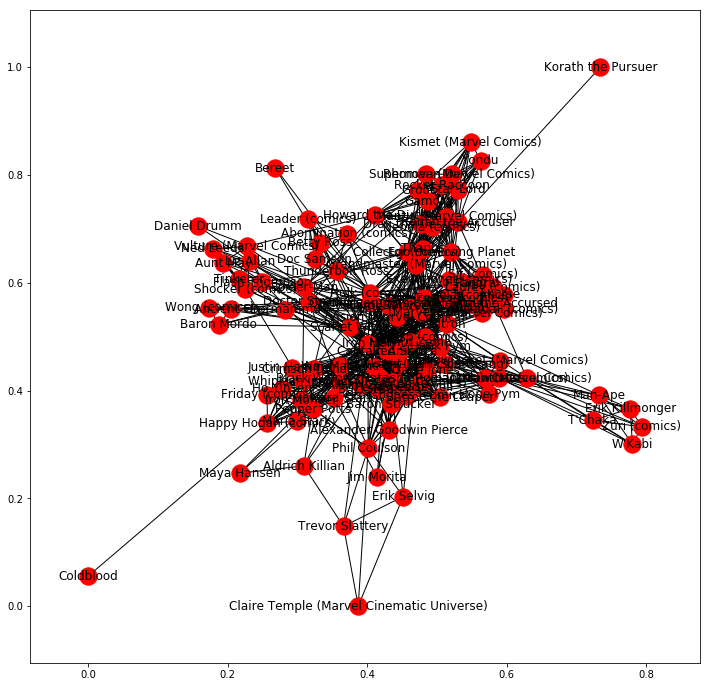

In [5]:
plt.figure(1, figsize=(12, 12))
nx.draw_networkx(graph)
plt.show()

### `make_interactive_graph`

The default graph options make it very difficult to read. Instead, you can use this `make_interactive_graph` function to make a clickable interactive graph with tool tips.

In [6]:
def make_interactive_graph(pos=None, cmap=plt.cm.viridis, edge_cmap=plt.cm.Reds, node_size_factor=5):
    import matplotlib
    import mpld3

    class ClickInfo(mpld3.plugins.PluginBase):
        """mpld3 Plugin for getting info on click
        Comes from:
            http://stackoverflow.com/a/28838652/814354
        """

        JAVASCRIPT = """
        mpld3.register_plugin("clickinfo", ClickInfo);
        ClickInfo.prototype = Object.create(mpld3.Plugin.prototype);
        ClickInfo.prototype.constructor = ClickInfo;
        ClickInfo.prototype.requiredProps = ["id", "urls"];
        function ClickInfo(fig, props){
            mpld3.Plugin.call(this, fig, props);
        };

        ClickInfo.prototype.draw = function(){
            var obj = mpld3.get_element(this.props.id);
            urls = this.props.urls;
            var elems = obj.elements();
            elems.on("mousedown",
                              function(d, i){
                                if (urls.length > 0) {
                                    window.open(urls[i], '_blank')}
                                });
            for (var i = 0; i < elems[0].length; i++) {
                elems[0][i].onmouseover = function() {
                    d3.select(this).transition().duration(100).style("fill-opacity", 1.0)
                        .style("stroke-opacity", 1.0)
                        .style("stroke-width", 3);
                }
                elems[0][i].onmouseout = function() {
                    d3.select(this).transition().duration(200).style("fill-opacity", 0.3)
                        .style("stroke-opacity", 0.3)
                        .style("stroke-width", 1);
                }
            }
        }
        """
        def __init__(self, points, urls):
            self.points = points
            self.urls = urls
            if isinstance(points, matplotlib.lines.Line2D):
                suffix = "pts"
            else:
                suffix = None
            self.dict_ = {"type": "clickinfo",
                          "id": mpld3.utils.get_id(points, suffix),
                          "urls": urls}
            


    fig = plt.figure(1, figsize=(8, 6), dpi=100)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    weights = [ d["weight"] for (u, v, d) in graph.edges(data=True)]
    degrees = nx.degree(graph)
    sizes = [ degrees[name] * node_size_factor for name in graph.nodes() ]
    urls = [ host + network_data[name]["url"] for name in graph.nodes() ]

    if pos is None:
        pos = nx.spring_layout(graph)

    nodes = nx.draw_networkx_nodes(graph, pos=pos, node_size=sizes, node_color=sizes, cmap=cmap, alpha=0.3)
    edges = nx.draw_networkx_edges(graph, pos=pos, edge_color=weights, edge_cmap=edge_cmap, arrows=False, alpha=0.3)

    tip_div = "<div style='background: #FFF; border-style: solid; border-width: 1px; padding: 2px;'>{}</div>"

    html_labels = list()
    for node in graph.nodes():
        neighbors = graph[node]
        neighbor_list = sorted([(neighbor, graph[node][neighbor]["weight"]) for neighbor in graph[node]], key=lambda tup: tup[1], reverse=True)[:3]
        list_label = "<br />".join(["{} ({})".format(neighbor[0], neighbor[1]) for neighbor in neighbor_list])
        html_labels.append( tip_div.format("<strong>{}</strong><br/><i>{}</i>".format(node, list_label)))

    line_labels = [ tip_div.format("<strong>{}</strong> and <strong>{}</strong> <i>({})</i>".format(u, v, d["weight"])) for (u, v, d) in graph.edges(data=True) ]

    tooltips = mpld3.plugins.PointHTMLTooltip(nodes, labels=html_labels, voffset=-10, hoffset=10)
    linetips = mpld3.plugins.PointHTMLTooltip(edges, labels=line_labels, voffset=-5, hoffset=10)
    mpld3.plugins.connect(fig, ClickInfo(nodes, urls))
    mpld3.plugins.connect(fig, ClickInfo(edges, []))
    mpld3.plugins.connect(fig, tooltips)
    mpld3.plugins.connect(fig, linetips)
    mpld3.enable_notebook()

You can run the `make_interactive_graph` function and specify some options for it. First, we are going to generate the layout of the graph using `nx.spring_layout`. You can use several types of layouts from the [`networkx` package](https://networkx.github.io/documentation/development/reference/drawing.html#layout). Next, we are also going to use a specific color map for the edges. You can use any of the [`matplotlib` color maps](http://matplotlib.org/examples/color/colormaps_reference.html).

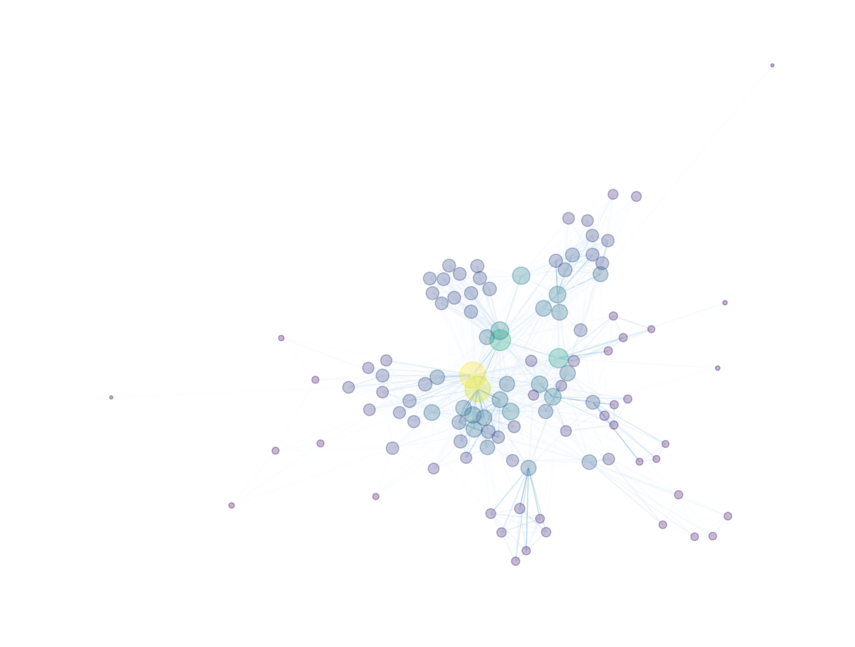

In [7]:
pos = nx.spring_layout(graph)
make_interactive_graph(pos=pos, edge_cmap=plt.cm.Blues)

### `save_big_graph`

If you would like to save a very high resolution version of this graph for use on a display system like [Texas Advanced Computing Center's Stallion](https://www.tacc.utexas.edu/vislab/stallion), you can use the `save_big_graph` function. The default output size at 600dpi will be 4800x3600 pixels.

In [27]:
def save_big_graph(pos=None, cmap=plt.cm.viridis, edge_cmap=plt.cm.Reds, dpi=600, font_size=1, node_size_factor=5, output_file="network.png"):
    import matplotlib
    weights = [ d["weight"] for (u, v, d) in graph.edges(data=True)]
    degrees = nx.degree(graph)
    sizes = [ degrees[name] * node_size_factor for name in graph.nodes() ]
    urls = [ host + network_data[name]["url"] for name in graph.nodes() ]

    print "Rendering hi-resolution image..."
    
    fig = plt.figure(1, figsize=(8, 6), dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    if pos is None:
        pos = nx.spring_layout(graph)

    nx.draw_networkx(graph, \
                     pos=pos, \
                     arrows=False, \
                     node_size=sizes, \
                     node_color=sizes, \
                     edge_color=weights, \
                     cmap=plt.cm.viridis, \
                     edge_cmap=plt.cm.Reds, \
                     font_size=font_size, \
                     alpha=0.3)

    print "Saving hi-resolution image to " + output_file + "..."

    fig.savefig(output_file)

In [ ]:
save_big_graph(pos=pos)